In [82]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [83]:
df = pd.read_csv("Data/data_pre.csv")
df = df.dropna()

# Standard, non-time-series (uncomment to run this)
df = df.drop(columns=['Unnamed: 0', 'DELAY_PREV_STD', 'DELAY_PREV_AVG'])

# Only Average (uncomment to run this)
#df = df.drop(columns=['Unnamed: 0', 'DELAY_PREV_STD'])

# Only STD (uncomment to run this)
#df = df.drop(columns=['Unnamed: 0', 'DELAY_PREV_AVG'])

# Both (uncomment to run this)
#df = df.drop(columns=['Unnamed: 0'])

In [84]:
y = df.DEP_DELAY
dates = df.FL_DATE
X = df.drop(["DEP_DELAY"],axis=1)
X["FL_DATE"] = pd.to_datetime(X["FL_DATE"]).dt.dayofyear
# Convert DEP_TIME to integer hour
X["DEP_TIME"] = pd.to_datetime(X["DEP_TIME"]).dt.hour
X


,FL_DATE,DEP_TIME,TAXI_OUT,TEMP,WIND,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_US,OP_CARRIER_United Airlines
0,1,22,18.0,34.7,12.4,0,0,0,1,0,0,0,0,0,0
1,1,16,21.0,38.1,12.9,0,0,0,1,0,0,0,0,0,0
2,1,22,23.0,34.7,12.4,0,0,0,1,0,0,0,0,0,0
3,1,10,23.0,35.4,13.0,0,0,0,1,0,0,0,0,0,0
4,1,18,31.0,36.5,12.8,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54175,181,6,18.0,69.2,8.0,0,0,0,0,0,0,0,0,0,1
54176,181,6,26.0,69.2,8.0,0,0,0,0,0,0,0,0,0,1
54177,181,18,27.0,75.1,13.0,0,0,0,0,0,0,0,0,1,0
54178,181,9,20.0,75.0,9.7,0,0,0,0,0,0,0,0,1,0


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# standardize input features
#X_train_mean = X_train.mean(axis=0)
#X_train_std = X_train.std(axis=0)
#X_train = (X_train - X_train_mean) / X_train_std

#X_test_mean = X_test.mean(axis=0)
#X_test_std = X_test.std(axis=0)
#X_test = (X_test - X_test_mean) / X_test_std

# standardize target
#y_train_mean = y_train.mean()
#y_train_std = y_train.std()
#y_train = (y_train - y_train_mean) / y_train_std

#y_test_mean = y_test.mean()
#y_test_std = y_test.std()
#y_test = (y_test - y_test_mean) / y_test_std


In [86]:
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 36300
num test: 17880


In [87]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

REALLY bad model

First a model with TAXI_OUT, DESTINATION and ORIGIN as inpot with same regression coefficients

In [88]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [89]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train.to_numpy()[:1000,:]).float()
y_train_small = torch.tensor(y_train.to_numpy()[:1000]).float()

In [90]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()


Sample: 100%|██████████| 1200/1200 [02:07,  9.39it/s, step size=9.67e-02, acc. prob=0.940]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.24      0.96      0.25     -1.34      1.82   1067.77      1.00
   beta[0]      0.03      0.07      0.02     -0.09      0.14    386.21      1.00
   beta[1]      1.26      0.23      1.27      0.92      1.65    951.47      1.00
   beta[2]      0.23      0.06      0.23      0.14      0.32    745.19      1.00
   beta[3]     -0.06      0.23     -0.05     -0.49      0.29    376.00      1.00
   beta[4]     -1.05      0.46     -1.05     -1.77     -0.21    442.40      1.00
   beta[5]      0.58      0.98      0.55     -0.99      2.15   1043.38      1.00
   beta[6]      0.51      0.96      0.50     -1.07      2.05   1357.00      1.00
   beta[7]     -0.01      1.03     -0.03     -1.79      1.59   1106.45      1.00
   beta[8]     -0.38      0.94     -0.42     -1.95      1.08   1747.80      1.00
   beta[9]     -0.05      0.99     -0.07     -1.74      1.52   1104.46      1.00
  beta[10]      0.38      0

In [91]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test.to_numpy(), posterior_samples["beta"].numpy().T), axis=1)

# Convert back to the original scale
preds = y_hat# * y_test_std + y_test_mean
y_true = y_test# * y_test_std + y_test_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.273
MAE: 20.309
RMSE: 36.615
R2: 0.069


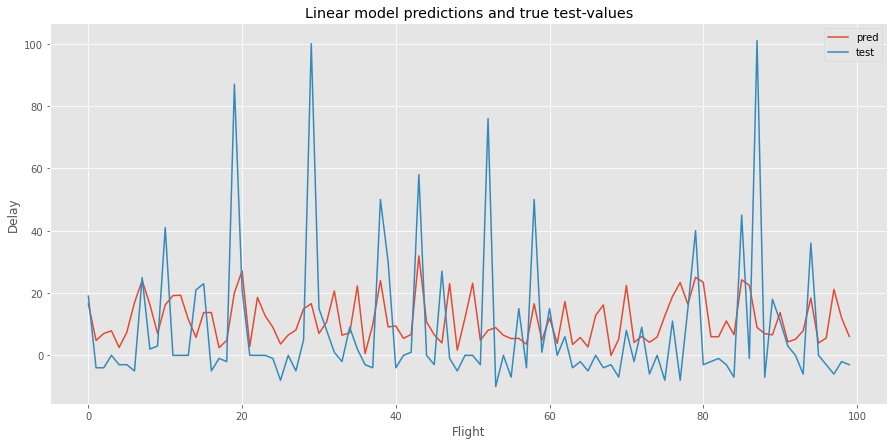

In [94]:
y_true = y_true.reset_index().drop('index',axis=1)
fig = plt.subplots(1,figsize=(15,7))
plt.plot(preds[:100],label='pred')
plt.plot(y_true[:100],label='test')
plt.title('Linear model predictions and true test-values')
plt.xlabel('Flight')
plt.ylabel('Delay')
plt.legend()
plt.savefig('Lin_reg_worst.png', dpi=300)